In [3]:
import pandas as pd
import numpy as np
import nltk
import sqlite3
import os
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, LSTM, Dropout
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [ ]:
con = sqlite3.connect("/content/gdrive/My Drive/Colab Notebooks/database.sqlite") 
filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con)

def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [7]:
#Deduplication of entries
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
final = final.sample(n=50000, replace=True)

In [ ]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 50000/50000 [00:16<00:00, 3051.25it/s]


In [ ]:
final['CleanedText'] = preprocessed_reviews

In [ ]:
x = final['CleanedText']
y = final['Score']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

In [ ]:
#Source: https://keras.io/preprocessing/text/
#Source: https://www.kaggle.com/kredy10/simple-lstm-for-text-classification
#Source: https://keras.io/preprocessing/sequence/

max_words = 5000
max_len = 600
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
train_sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [17]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(max_words+1, embedding_vecor_length, input_length=max_len))
model.add(LSTM(100, dropout = 0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(100, dropout = 0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 600, 100)          400       
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 294,133
Trainable params: 293,933
Non-trainable params: 200
_____________

In [18]:
history = model.fit(train_sequences_matrix, y_train, epochs=10, batch_size=100, validation_data=(test_sequences_matrix, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 35000 samples, validate on 15000 samples
Epoch 1/10
35000/35000 [==============================] - 771s 22ms/step - loss: 0.2920 - acc: 0.8836 - val_loss: 0.2549 - val_acc: 0.9053
Epoch 2/10
35000/35000 [==============================] - 771s 22ms/step - loss: 0.1909 - acc: 0.9253 - val_loss: 0.2202 - val_acc: 0.9131
Epoch 3/10
35000/35000 [==============================] - 770s 22ms/step - loss: 0.1620 - acc: 0.9378 - val_loss: 0.2265 - val_acc: 0.9151
Epoch 4/10
35000/35000 [==============================] - 769s 22ms/step - loss: 0.1434 - acc: 0.9456 - val_loss: 0.2207 - val_acc: 0.9197
Epoch 5/10
35000/35000 [==============================] - 773s 22ms/step - loss: 0.1346 - acc: 0.9496 - val_loss: 0.2457 - val_acc: 0.9144
Epoch 6/10
35000/35000 [==============================] - 773s 22ms/step - loss: 0.1189 - acc: 0.9562 - val_loss: 0.2365 - val_acc: 0.9193
Epoch 7/10
35000/35000 [==============================] - 773s 22ms/

In [19]:
scores = model.evaluate(test_sequences_matrix, y_test, verbose=0)
model2_acc = scores[1]
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 91.69%


Test score: 0.3049351974586646
Test accuracy: 0.9169333333651225


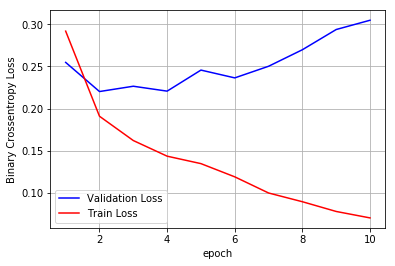

In [20]:
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,11))

vy = history.history['val_loss']
ty = history.history['loss']


plt_dynamic(x, vy, ty, ax)

In [21]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(max_words+1, embedding_vecor_length, input_length=max_len))
model.add(LSTM(100, dropout = 0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(100, dropout = 0.5, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_3 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
batch_normalization_2 (Batch (None, 600, 100)          400       
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 294,133
Trainable params: 293,933
Non-trainable params: 200
_________________________________________________________________
None


In [22]:
history = model.fit(train_sequences_matrix, y_train, epochs=10, batch_size=100, validation_data=(test_sequences_matrix, y_test))

Train on 35000 samples, validate on 15000 samples
Epoch 1/10
35000/35000 [==============================] - 778s 22ms/step - loss: 0.2911 - acc: 0.8842 - val_loss: 0.2121 - val_acc: 0.9165
Epoch 2/10
35000/35000 [==============================] - 778s 22ms/step - loss: 0.1897 - acc: 0.9248 - val_loss: 0.2191 - val_acc: 0.9161
Epoch 3/10
35000/35000 [==============================] - 780s 22ms/step - loss: 0.1666 - acc: 0.9374 - val_loss: 0.2104 - val_acc: 0.9205
Epoch 4/10
35000/35000 [==============================] - 778s 22ms/step - loss: 0.1476 - acc: 0.9447 - val_loss: 0.2258 - val_acc: 0.9194
Epoch 5/10
35000/35000 [==============================] - 779s 22ms/step - loss: 0.1454 - acc: 0.9453 - val_loss: 0.2256 - val_acc: 0.9187
Epoch 6/10
35000/35000 [==============================] - 772s 22ms/step - loss: 0.1314 - acc: 0.9510 - val_loss: 0.2409 - val_acc: 0.9177
Epoch 7/10
35000/35000 [==============================] - 777s 22ms/step - loss: 0.1149 - acc: 0.9593 - val_loss: 0.

In [23]:
scores = model.evaluate(test_sequences_matrix, y_test, verbose=0)
model3_acc = scores[1]
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 91.53%


Test score: 0.3190554770519336
Test accuracy: 0.9152666666348775


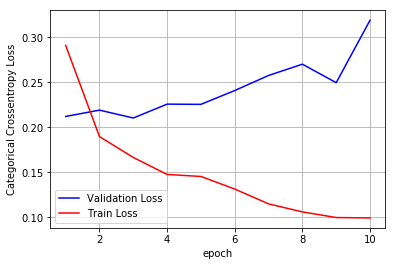

In [24]:
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,11))


vy = history.history['val_loss']
ty = history.history['loss']

plt_dynamic(x, vy, ty, ax)

In [25]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(max_words+1, embedding_vecor_length, input_length=max_len))
model.add(LSTM(100, dropout = 0.7, recurrent_dropout=0.7, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(100, dropout = 0.5, recurrent_dropout=0.5, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(100, dropout = 0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_5 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
batch_normalization_3 (Batch (None, 600, 100)          400       
_________________________________________________________________
lstm_6 (LSTM)                (None, 600, 100)          80400     
_________________________________________________________________
batch_normalization_4 (Batch (None, 600, 100)          400       
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total para

In [26]:
history = model.fit(train_sequences_matrix, y_train, epochs=10, batch_size=100, validation_data=(test_sequences_matrix, y_test))

Train on 35000 samples, validate on 15000 samples
Epoch 1/10
35000/35000 [==============================] - 1169s 33ms/step - loss: 0.3880 - acc: 0.8478 - val_loss: 0.2912 - val_acc: 0.8879
Epoch 2/10
35000/35000 [==============================] - 1167s 33ms/step - loss: 0.2695 - acc: 0.8907 - val_loss: 0.2452 - val_acc: 0.9081
Epoch 3/10
35000/35000 [==============================] - 1164s 33ms/step - loss: 0.2310 - acc: 0.9081 - val_loss: 0.2347 - val_acc: 0.9026
Epoch 4/10
35000/35000 [==============================] - 1169s 33ms/step - loss: 0.2151 - acc: 0.9154 - val_loss: 0.2216 - val_acc: 0.9169
Epoch 5/10
35000/35000 [==============================] - 1165s 33ms/step - loss: 0.1997 - acc: 0.9212 - val_loss: 0.2274 - val_acc: 0.9078
Epoch 6/10
35000/35000 [==============================] - 1172s 33ms/step - loss: 0.2054 - acc: 0.9189 - val_loss: 0.2251 - val_acc: 0.9112
Epoch 7/10
35000/35000 [==============================] - 1169s 33ms/step - loss: 0.1871 - acc: 0.9274 - val_l

In [27]:
scores = model.evaluate(test_sequences_matrix, y_test, verbose=0)
model4_acc = scores[1]
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 91.63%


Test score: 0.22179906602303187
Test accuracy: 0.9163333333015442


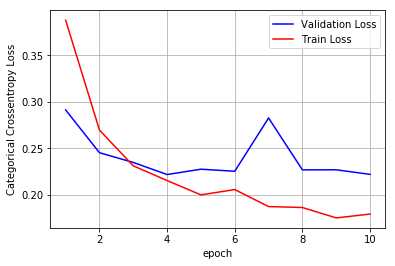

In [28]:
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,11))


vy = history.history['val_loss']
ty = history.history['loss']

plt_dynamic(x, vy, ty, ax)

In [29]:
from prettytable import PrettyTable

model_metric = PrettyTable()

model_metric = PrettyTable(["Model", "# LSTM Layers", 'Test Accuracy'])

model_metric.add_row(['LSTM','2 layers','%.4f%%' %model2_acc])
model_metric.add_row(['LSTM','2 layer','%.4f%%' %model3_acc])
model_metric.add_row(['LSTM','3 layers','%.4f%%' %model4_acc])
print(model_metric.get_string(start=0, end=8))

+-------+---------------+---------------+
| Model | # LSTM Layers | Test Accuracy |
+-------+---------------+---------------+
|  LSTM |    2 layers   |    0.9169%    |
|  LSTM |    2 layer    |    0.9153%    |
|  LSTM |    3 layers   |    0.9163%    |
+-------+---------------+---------------+
